In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dedalus import public as de

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# PROBLEMS

In [3]:
# BUILD BASES AND DOMAINS
x_basis = de.Chebyshev('x', 1024, interval=(0, 300), dealias=2)
domain = de.Domain([x_basis], grid_dtype=np.complex128)
# BUILD PROBLEM
problem = de.IVP(domain, variables=['u', 'ux'])

In [4]:
# PARAMETERS AND NON CONSTANT DEFINATIONS
problem.parameters['b'] = 0.5
problem.parameters['c'] = -1.76

In [5]:
#SUBSTITUTIONS
problem.substitutions["mag_sq(A)"] = "A * conj(A)"

In [6]:
# WRITING EQUATIONS - GINZBERG-LANDAU EQN.(CGLE)
# Add main equation, with linear terms on the LHS and nonlinear terms on the RHS
problem.add_equation("dt(u) - u - (1 + 1j*b)*dx(ux) = - (1 + 1j*c) * mag_sq(u) * u")
# Add auxiliary equation defining the first-order reduction
problem.add_equation("ux - dx(u) = 0")
# Add boundary conditions
problem.add_equation("left(u) = 0")
problem.add_equation("right(u) = 0")

In [7]:
# Build solver
solver = problem.build_solver('RK222')

2021-08-05 21:52:54,033 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s


In [8]:
# Stopping criteria
solver.stop_sim_time = 500
solver.stop_wall_time = np.inf
solver.stop_iteration = np.inf

In [9]:
# Reference local grid and state fields
x = domain.grid(0)
u = solver.state['u']
ux = solver.state['ux']
# Setup a sine wave
u.set_scales(1)
u['g'] = 1e-3 * np.sin(5 * np.pi * x / 300)
u.differentiate('x', out=ux);

In [12]:
# Setup storage
u.set_scales(1)
u_list = [np.copy(u['g'])]
t_list = [solver.sim_time]
# Main loop
dt = 0.05
while solver.ok:
    solver.step(dt)
    if solver.iteration % 10 == 0:
        u.set_scales(1)
        u_list.append(np.copy(u['g']))
        t_list.append(solver.sim_time)
    if solver.iteration % 1000 == 0:
        print('Completed iteration {}'.format(solver.iteration))

# Convert storage lists to arrays
u_array = np.array(u_list)
t_array = np.array(t_list)

Completed iteration 1000
Completed iteration 2000
Completed iteration 3000
Completed iteration 4000
Completed iteration 5000
Completed iteration 6000
Completed iteration 7000
Completed iteration 8000
Completed iteration 9000
Completed iteration 10000
2021-08-05 21:57:29,742 solvers 0/1 INFO :: Simulation stop time reached.


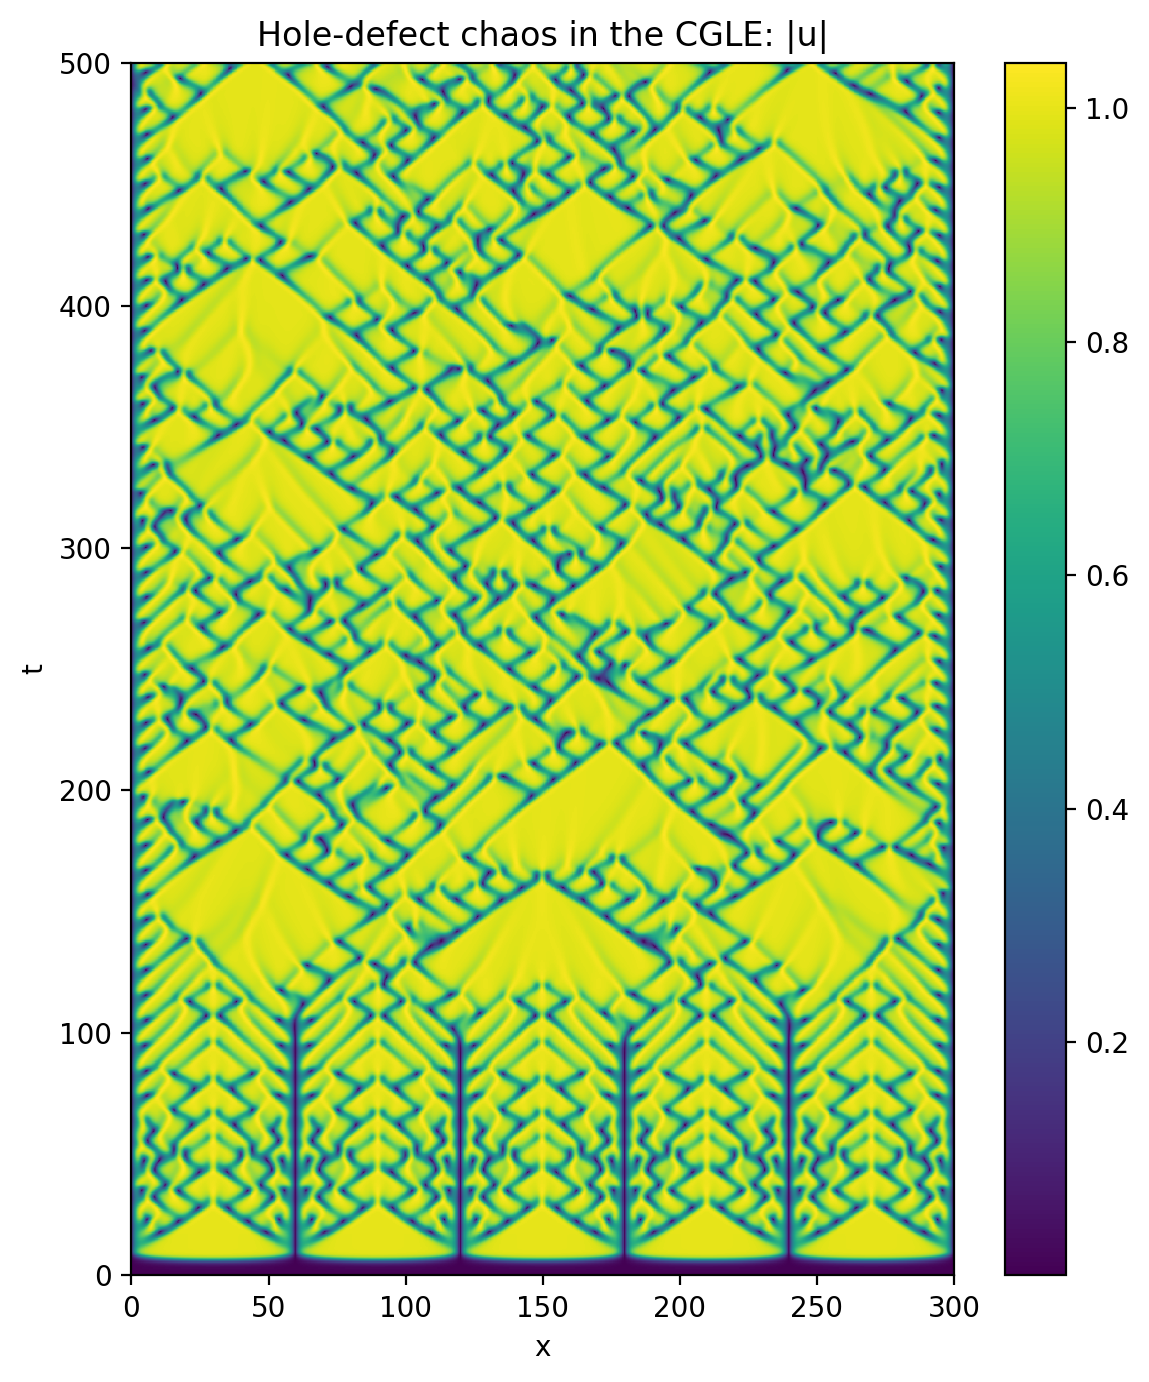

In [13]:
# Plot solution
plt.figure(figsize=(6, 7), dpi=100)
plt.pcolormesh(x, t_array, np.abs(u_array), shading='nearest')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Hole-defect chaos in the CGLE: |u|')
plt.tight_layout()